In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import array
from array import *
import random
import time
import math
from sklearn import model_selection
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

D:\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv('D:\Parkinson\data.csv')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


In [3]:
features=df.loc[:,df.columns!='status'].values[:,1:]
labels=df.loc[:,'status'].values[:]

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler=MinMaxScaler((-1,1))
real_x=scaler.fit_transform(features)
real_y=labels

In [6]:
training_x, testing_x, training_y, testing_y=train_test_split(real_x,real_y,test_size=0.2,random_state=7)

In [7]:
print(training_x.shape)
print(testing_x.shape)
print(training_y.shape)
print(testing_y.shape)

(156, 22)
(39, 22)
(156,)
(39,)


In [8]:
def specificity(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    speci = 1 - fpr[1]
    return speci

scorer = make_scorer(specificity)

In [9]:
def objf(wts, models):
    
    model = VotingClassifier(estimators=[('m1', models[0]), ('m2', models[1]), ('m3', models[2]), ('m4', models[3]), 
                                         ('m5', models[4])], 
                             voting='soft', weights = wts)
    
    model.fit(training_x, training_y)
    final_pred = model.predict(testing_x)
    c_m = confusion_matrix(testing_y, final_pred)
    fitness = (c_m[0][1] + c_m[1][0])/(c_m[0][0] + c_m[0][1] + c_m[1][0] + c_m[1][1])
    return fitness

In [10]:
def GWO(objf,models):
    
    Max_iter=1000
    lb= 0
    ub= 1
    dim=5  
    SearchAgents_no=10
    
    # initialize alpha, beta, and delta_pos
    Alpha_pos=np.zeros(dim)
    Alpha_score=float("inf")
    
    Beta_pos=np.zeros(dim)
    Beta_score=float("inf")
    
    Delta_pos=np.zeros(dim)
    Delta_score=float("inf")
    
    pos = np.ones(dim)
    score = float("inf")

    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim
    
    #Initialize the positions of search agents
    Positions = np.zeros((SearchAgents_no, dim))
    for i in range(dim):
        Positions[:, i] = np.random.uniform(0,1, SearchAgents_no) * (ub[i] - lb[i]) + lb[i]
    
    Convergence_curve=np.zeros(Max_iter)

     # Loop counter
    print("GWO is optimizing  \""+objf.__name__+"\"")    
    
    # Main loop
    for l in range(0,Max_iter):
        for i in range(0,SearchAgents_no):
            
            # Return back the search agents that go beyond the boundaries of the search space
            for j in range(dim):
                Positions[i,j]=np.clip(Positions[i,j], lb[j], ub[j])

            # Calculate objective function for each search agent
            fitness=objf(Positions[i,:], models)
            
            # Update Alpha, Beta, and Delta
            if fitness<Alpha_score :
                Alpha_score=fitness; # Update alpha
                Alpha_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness<Beta_score ):
                Beta_score=fitness  # Update beta
                Beta_pos=Positions[i,:].copy()
            
            
            if (fitness>Alpha_score and fitness>Beta_score and fitness<Delta_score): 
                Delta_score=fitness # Update delta
                Delta_pos=Positions[i,:].copy()
            
        
        
        
        #a=2-l*((2)/Max_iter); # a decreases linearly fron 2 to 0
   #     a=2*(1-((l*l)/(Max_iter*Max_iter)));
        a = 2*(1 - (math.sin((l*math.pi)/(2*Max_iter))))
        # Update the Position of search agents including omegas
        for i in range(0,SearchAgents_no):
            for j in range (0,dim):     
                           
                r1=random.random() # r1 is a random number in [0,1]
                r2=random.random() # r2 is a random number in [0,1]
                
                A1=2*a*r1-a; # Equation (3.3)
                C1=2*r2; # Equation (3.4)
                
                D_alpha=abs(C1*Alpha_pos[j]-Positions[i,j]); # Equation (3.5)-part 1
                X1=Alpha_pos[j]-A1*D_alpha; # Equation (3.6)-part 1
                           
                r1=random.random()
                r2=random.random()
                
                A2=2*a*r1-a; # Equation (3.3)
                C2=2*r2; # Equation (3.4)
                
                D_beta=abs(C2*Beta_pos[j]-Positions[i,j]); # Equation (3.5)-part 2
                X2=Beta_pos[j]-A2*D_beta; # Equation (3.6)-part 2       
                
                r1=random.random()
                r2=random.random() 
                
                A3=2*a*r1-a; # Equation (3.3)
                C3=2*r2; # Equation (3.4)
                
                D_delta=abs(C3*Delta_pos[j]-Positions[i,j]); # Equation (3.5)-part 3
                X3=Delta_pos[j]-A3*D_delta; # Equation (3.5)-part 3             
#                 fi=0.5*(np.arctan(l))
#                 th=(2/(math.pi))*(np.arccos(1/3))*(np.arctan(l))
#                 w1=math.cos(th)
#                 w2=0.5*(math.sin(th))*(math.cos(fi))
#                 w3=1-w1-w2
#                 Positions[i,j]=((w1*X1)+(w2*X2)+(w3*X3))  # Equation (3.7)
                Positions[i,j]=(X1+X2+X3)/3
            if(score>Alpha_score):
                score = Alpha_score
                pos = Alpha_pos
    
    return pos



In [11]:
acc = array('f', [])

pre = array('f', [])

recall = array('f', [])

f_m = array('f', [])

roc = array('f', [])

speci = array('f', [])

models = []

In [12]:
model1 = KNeighborsClassifier(n_neighbors = 2, metric = 'minkowski', p = 2)
models.append(model1)#76.27

model2 = SVC(kernel = "rbf", random_state = 0, gamma = 0.1, probability = True)
models.append(model2)#79.66

model3 = XGBClassifier()
models.append(model3)#91.52

model4 = DecisionTreeClassifier(criterion='entropy',max_depth=6,random_state=100,min_samples_leaf=5)
models.append(model4)#89.83

model5 = RandomForestClassifier(n_estimators = 50)
models.append(model5)#88.13

In [13]:
start = time.time()
wts = GWO(objf, models)

model = VotingClassifier(estimators=[('m1', model1), ('m2', model2), ('m3', model3), ('m4', model4), 
                                     ('m5', model5)], voting='soft', weights = wts)

end = time.time()
print("time of execution is =", (end - start))

GWO is optimizing  "objf"
time of execution is = 5995.388437747955


In [14]:
model.fit(training_x, training_y)
final_pred = model.predict(testing_x)

In [15]:
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [16]:
print('Model Accuracy : {} %'.format(accuracy_score(testing_y,final_pred)*100))
print('Model precision : {} %'.format(precision_score(testing_y,final_pred)*100))
print('Model recall : {} %'.format(recall_score(testing_y,final_pred)*100))

Model Accuracy : 97.43589743589743 %
Model precision : 96.96969696969697 %
Model recall : 100.0 %


In [17]:
count_misclassified = (testing_y != final_pred).sum()
print('Misclassified samples in model: {}'.format(count_misclassified))

Misclassified samples in model: 1


In [18]:
#final_pred
wts

array([0.8561172 , 0.53513208, 0.46228808, 0.17183262, 0.22595059])

In [19]:
c_m = confusion_matrix(testing_y, final_pred)
c_m

array([[ 6,  1],
       [ 0, 32]], dtype=int64)

<AxesSubplot:>

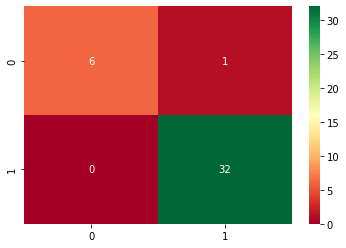

In [20]:
import seaborn as sns
sns.heatmap(c_m, annot = True,cmap = 'RdYlGn')

In [21]:
score = model_selection.cross_val_score(model, real_x, real_y, cv = 20, scoring = 'accuracy')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 20, scoring = 'precision')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 20, scoring = 'recall')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 20, scoring = 'f1')
print(score.mean())

0.9116666666666667
0.9287698412698413
0.9517857142857145
0.9383424908424909


In [22]:
score = model_selection.cross_val_score(model, real_x, real_y, cv = 30, scoring = 'accuracy')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 30, scoring = 'precision')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 30, scoring = 'recall')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 30, scoring = 'f1')
print(score.mean())

0.9261904761904761
0.9461111111111111
0.9716666666666666
0.9520033670033671


In [23]:
score


array([1.        , 0.88888889, 1.        , 1.        , 1.        ,
       1.        , 0.90909091, 1.        , 0.90909091, 1.        ,
       0.88888889, 1.        , 1.        , 0.90909091, 1.        ,
       1.        , 1.        , 1.        , 0.88888889, 1.        ,
       1.        , 0.90909091, 0.90909091, 0.8       , 1.        ,
       1.        , 0.90909091, 1.        , 0.75      , 0.88888889])

In [24]:
score = model_selection.cross_val_score(model, real_x, real_y, cv = 10, scoring = 'accuracy')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 10, scoring = 'precision')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 10, scoring = 'recall')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 10, scoring = 'f1')
print(score.mean())

0.8913157894736841
0.914656862745098
0.9523809523809523
0.9306991895757191


In [25]:
score


array([0.92857143, 1.        , 0.90322581, 0.93333333, 1.        ,
       0.96774194, 0.96551724, 0.90322581, 0.83870968, 0.86666667])

In [26]:
score = model_selection.cross_val_score(model, real_x, real_y, cv = 5, scoring = 'accuracy')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 5, scoring = 'precision')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 5, scoring = 'recall')
print(score.mean())
score = model_selection.cross_val_score(model, real_x, real_y, cv = 5, scoring = 'f1')
print(score.mean())

0.8051282051282052
0.8235563195501525
0.9528735632183908
0.881471318252105
